In [ ]:
import os
import gc
import torch
import random
import time
import psutil
import logging
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim import Adam
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import glue_processors as processors
from transformers import glue_output_modes as output_modes
from transformers import glue_convert_examples_to_features as convert_examples_to_features

In [2]:
class TrainingArgs:
    def __init__(self):
        self.bert_model = 'bert-base-uncased'
        self.local_rank = -1
        self.data_dir = "glue_data"
        self.overwrite_cache = True
        self.num_labels = 2
        self.batch_size = 8
        self.update_lr = 5e-5
        self.epochs = 3
        self.output_dir = "baseline"
        self.train_sample_per_task = 500
        self.eval_sample_per_task = 100
        self.seed = 140
        self.memory_size = 2000  

args = TrainingArgs()

In [3]:
logger=logging.getLogger()

In [5]:
class BertTask_Baseline(Dataset):
    ''' 
    Custom dataset class that loads and preprocesses GLUE datasets.
    It takes a specific task and converts the raw text into tokenized features ready for training or evaluation.
    load_and_cache_examples method handles the loading and caching of the dataset examples.
    '''
    def __init__(self, args, tokenizer, max_seq_length, task, evaluate=False,sample=False):
        """
        :param num_task: number of training tasks.
        :param tokenizer: tokenizer uses to tokenzie from word to sequence
        :param max_seq_length: length of the tokenzier vector
        :param evaluate: indicate whether the dataset is from training/ evaluate sets
        """
        self.tokenizer       = tokenizer
        self.max_seq_length  = max_seq_length
        self.evaluate        = evaluate
        self.local_rank      = args.local_rank
        self.data_dir        = args.data_dir
        self.bert_model      = args.bert_model
        self.overwrite_cache = args.overwrite_cache
        self.sample = sample
        self.task = task
        self.create_batch()
        
    def create_batch(self):
        '''
        Randomly select number of examples from each task into supports (meta training dataset) and queries (meta evaluating dataset)
        '''
        # 1. randomly select num_task GLUE tasks 
        task = self.task 
        self.dataset = self.load_and_cache_examples(task, self.tokenizer, self.evaluate, self.sample) # map style dataset 


    def load_and_cache_examples(self, task, tokenizer, evaluate=False, sample=False):
        '''
        Copied from official loading and cache scripts from Huggingface Transformer load_and_cache_examples
        https://github.com/huggingface/transformers/blob/master/examples/run_glue.py#L334
        '''
        folder_name = {'cola': 'CoLA', 'mnli-mm':'MNLI'}
        if task in folder_name:
            task_data_path = folder_name[task]
        else:
            task_data_path = task.upper()


        if self.local_rank not in [-1, 0] and not evaluate:
            torch.distributed.barrier()  
            
        processor = processors[task]()
        output_mode = output_modes[task]
        cached_downloaded_file = os.path.join(self.data_dir, task_data_path)
        # print(cached_downloaded_file)

        logger.info(f"Creating features from dataset file at {cached_downloaded_file}")
        label_list = processor.get_labels()

    
        examples = (
                processor.get_dev_examples(cached_downloaded_file) if evaluate else processor.get_train_examples(cached_downloaded_file)
            )
        
        if sample:
            if args.seed:
                random.seed(args.seed)
            examples = random.sample(examples, sample)

        features = convert_examples_to_features(
            examples, tokenizer, max_length=self.max_seq_length, label_list=label_list, output_mode=output_mode,
        )

        if self.local_rank == 0 and not evaluate:
            torch.distributed.barrier()  
            
        # Convert to Tensors and build dataset
        all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
        all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
        all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
        if output_mode == "classification":
            all_labels = torch.tensor([f.label for f in features], dtype=torch.long)
        elif output_mode == "regression":
            all_labels = torch.tensor([f.label for f in features], dtype=torch.float)

        dataset = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_labels)
        return dataset

    def __getitem__(self, index):
        dataset_set = self.dataset[index]
        return dataset_set

    def __len__(self):
        return len(self.dataset)

In [6]:
class Bert_trainer(nn.Module):

    def __init__(self, args):
        """
        :param args:
        """
        super(Bert_trainer, self).__init__()

        self.num_labels = args.num_labels
        self.batch_size = args.batch_size
        self.update_lr  = args.update_lr
    

        self.bert_model = args.bert_model
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        self.model = BertForSequenceClassification.from_pretrained(self.bert_model, num_labels = self.num_labels)
        self.outer_optimizer = Adam(self.model.parameters(), lr=self.update_lr)
        self.model.train()

    def forward(self, datasets,training=True):
        """
        batch_tasks = TensorDataset(all_input_ids, all_attention_mask, all_segment_ids, all_label_ids)
        """

        num_task = len(datasets)
        self.model.to(self.device)
        acc = None

        
        if training:
            dataloader = DataLoader(datasets,batch_size=self.batch_size)
            for data in dataloader:
                all_loss = []
                batch = tuple(t.to(self.device) for t in data)
                input_ids, attention_mask, segment_ids, label_id = batch
                outputs = self.model(input_ids, attention_mask, segment_ids, labels = label_id)
                loss = outputs[0]              
                loss.backward()
                self.outer_optimizer.step()
                self.outer_optimizer.zero_grad()
                all_loss.append(loss.item())
            self.model.to(torch.device('cpu'))
            return outputs
        else:
            
            with torch.no_grad():
                correct = 0
                total = 0
                self.model.to(torch.device(self.device))
                dataloader = DataLoader(datasets,batch_size=self.batch_size)
                for data in dataloader:
                    
                    query_batch = next(iter(dataloader))
                    query_batch = tuple(t.to(self.device) for t in query_batch)
                    q_input_ids, q_attention_mask, q_segment_ids, q_label_id = query_batch
                    q_outputs = self.model(q_input_ids, q_attention_mask, q_segment_ids, labels = q_label_id)
                
                    q_logits = F.softmax(q_outputs[1],dim=1)
                    pre_label_id = torch.argmax(q_logits,dim=1)
                    total += q_label_id.size(0)
                    correct += pre_label_id.eq(q_label_id.to(self.device).view_as(pre_label_id)).sum().item()
                acc = correct/total
                self.model.to(torch.device('cpu'))
        return acc

def calculate_memory_usage():
    process = psutil.Process()
    memory_info = process.memory_info()
    return memory_info.rss  
    
def calculate_compute_time(start_time, end_time):
    return end_time - start_time

In [7]:
random.seed(140)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
task_lists = ["cola", "sst-2", "mrpc", "qnli", "rte", "qqp"]

In [8]:
my_Bert = Bert_trainer(args)
acc_results = []
saving_path = os.path.join(args.output_dir,"base_model")
if  not os.path.exists(saving_path):
    os.makedirs(saving_path)

for i,task in enumerate(task_lists):
    train_data = BertTask_Baseline(args, tokenizer, 128, task,sample=args.train_sample_per_task)
    print("Training on the {} task".format(task))
    start_time = time.time()
    for epoch in range(args.epochs):
        outputs = my_Bert(train_data)
    end_time = time.time()
    print("_____***Saving Model***___{}".format(task))
    
    torch.save(my_Bert.state_dict(), os.path.join(saving_path,"{}_params.pkl".format(task)))

    memory_usage = calculate_memory_usage()
    compute_time = calculate_compute_time(start_time, end_time)

    print("Memory usage for task {}: {:.2f} MB".format(task, memory_usage / 1024 / 1024))
    print("Compute time for task {}: {:.2f} seconds".format(task, compute_time))

    del train_data
    _ = gc.collect()
    
    ### Evaluating
    accs = []
    for j in range(i+1):
        eval_task = task_lists[j]
        print("_____Evalating on the {}".format(eval_task))
        eval_data = BertTask_Baseline(args, tokenizer,128,eval_task,evaluate=True,sample=args.eval_sample_per_task)
        acc = my_Bert(eval_data,training=False)
        accs.append(acc)
        del eval_data
        _ = gc.collect()
        print("_____Finishing evalating on the {}".format(eval_task))
    acc_results.append(accs)
    print("Finishing training on the {} task".format(task))


acc_results_pad = [line+[""]*(6-len(line)) for line in acc_results]
final_acc = "\n".join([",".join(list(map(str,line))) for line in acc_results_pad])
    
with open(os.path.join(args.output_dir,"results.txt"),"w") as f:
    f.write(",".join(task_lists))
    f.write("\n")
    f.write(final_acc)



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/u_405226/.local/lib/python3.11/site-packages/transformers/data/processors/glue.py:283: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/home/u_405226/.local/lib/python3.11/site-packages/transformers/data/processors/glue.py:66: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this exa

Training on the cola task
_____***Saving Model***___cola
Memory usage for task cola: 1962.14 MB
Compute time for task cola: 33.24 seconds
_____Evalating on the cola
_____Finishing evalating on the cola
Finishing training on the cola task


/home/u_405226/.local/lib/python3.11/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Training on the sst-2 task
_____***Saving Model***___sst-2
Memory usage for task sst-2: 1984.89 MB
Compute time for task sst-2: 32.22 seconds
_____Evalating on the cola
_____Finishing evalating on the cola
_____Evalating on the sst-2
_____Finishing evalating on the sst-2
Finishing training on the sst-2 task


/home/u_405226/.local/lib/python3.11/site-packages/transformers/data/processors/glue.py:174: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Training on the mrpc task
_____***Saving Model***___mrpc
Memory usage for task mrpc: 2020.02 MB
Compute time for task mrpc: 32.72 seconds
_____Evalating on the cola
_____Finishing evalating on the cola
_____Evalating on the sst-2
_____Finishing evalating on the sst-2
_____Evalating on the mrpc
_____Finishing evalating on the mrpc
Finishing training on the mrpc task


/home/u_405226/.local/lib/python3.11/site-packages/transformers/data/processors/glue.py:474: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence 

Training on the qnli task
_____***Saving Model***___qnli
Memory usage for task qnli: 2023.92 MB
Compute time for task qnli: 32.67 seconds
_____Evalating on the cola
_____Finishing evalating on the cola
_____Evalating on the sst-2
_____Finishing evalating on the sst-2
_____Evalating on the mrpc


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


_____Finishing evalating on the mrpc
_____Evalating on the qnli
_____Finishing evalating on the qnli
Finishing training on the qnli task


/home/u_405226/.local/lib/python3.11/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence 

Training on the rte task
_____***Saving Model***___rte
Memory usage for task rte: 2023.02 MB
Compute time for task rte: 32.89 seconds
_____Evalating on the cola
_____Finishing evalating on the cola
_____Evalating on the sst-2
_____Finishing evalating on the sst-2
_____Evalating on the mrpc


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


_____Finishing evalating on the mrpc
_____Evalating on the qnli


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

_____Finishing evalating on the qnli
_____Evalating on the rte
_____Finishing evalating on the rte
Finishing training on the rte task


/home/u_405226/.local/lib/python3.11/site-packages/transformers/data/processors/glue.py:422: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Training on the qqp task
_____***Saving Model***___qqp
Memory usage for task qqp: 2030.95 MB
Compute time for task qqp: 32.57 seconds
_____Evalating on the cola
_____Finishing evalating on the cola
_____Evalating on the sst-2
_____Finishing evalating on the sst-2
_____Evalating on the mrpc


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


_____Finishing evalating on the mrpc
_____Evalating on the qnli


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

_____Finishing evalating on the qnli
_____Evalating on the rte
_____Finishing evalating on the rte
_____Evalating on the qqp
_____Finishing evalating on the qqp
Finishing training on the qqp task


In [29]:
acc_mtx = pd.read_csv(os.path.join(args.output_dir,"results.txt"))
acc_mtx

,cola,sst-2,mrpc,qnli,rte,qqp
0,0.776316,NaN,NaN,NaN,NaN,NaN
1,0.740132,0.621711,NaN,NaN,NaN,NaN
2,0.713816,0.726974,0.740132,NaN,NaN,NaN
3,0.526316,0.608553,0.865132,0.470395,NaN,NaN
4,0.750000,0.506579,0.687500,0.250000,0.410714,NaN
5,0.345395,0.506579,0.164474,0.740132,0.425000,0.539474


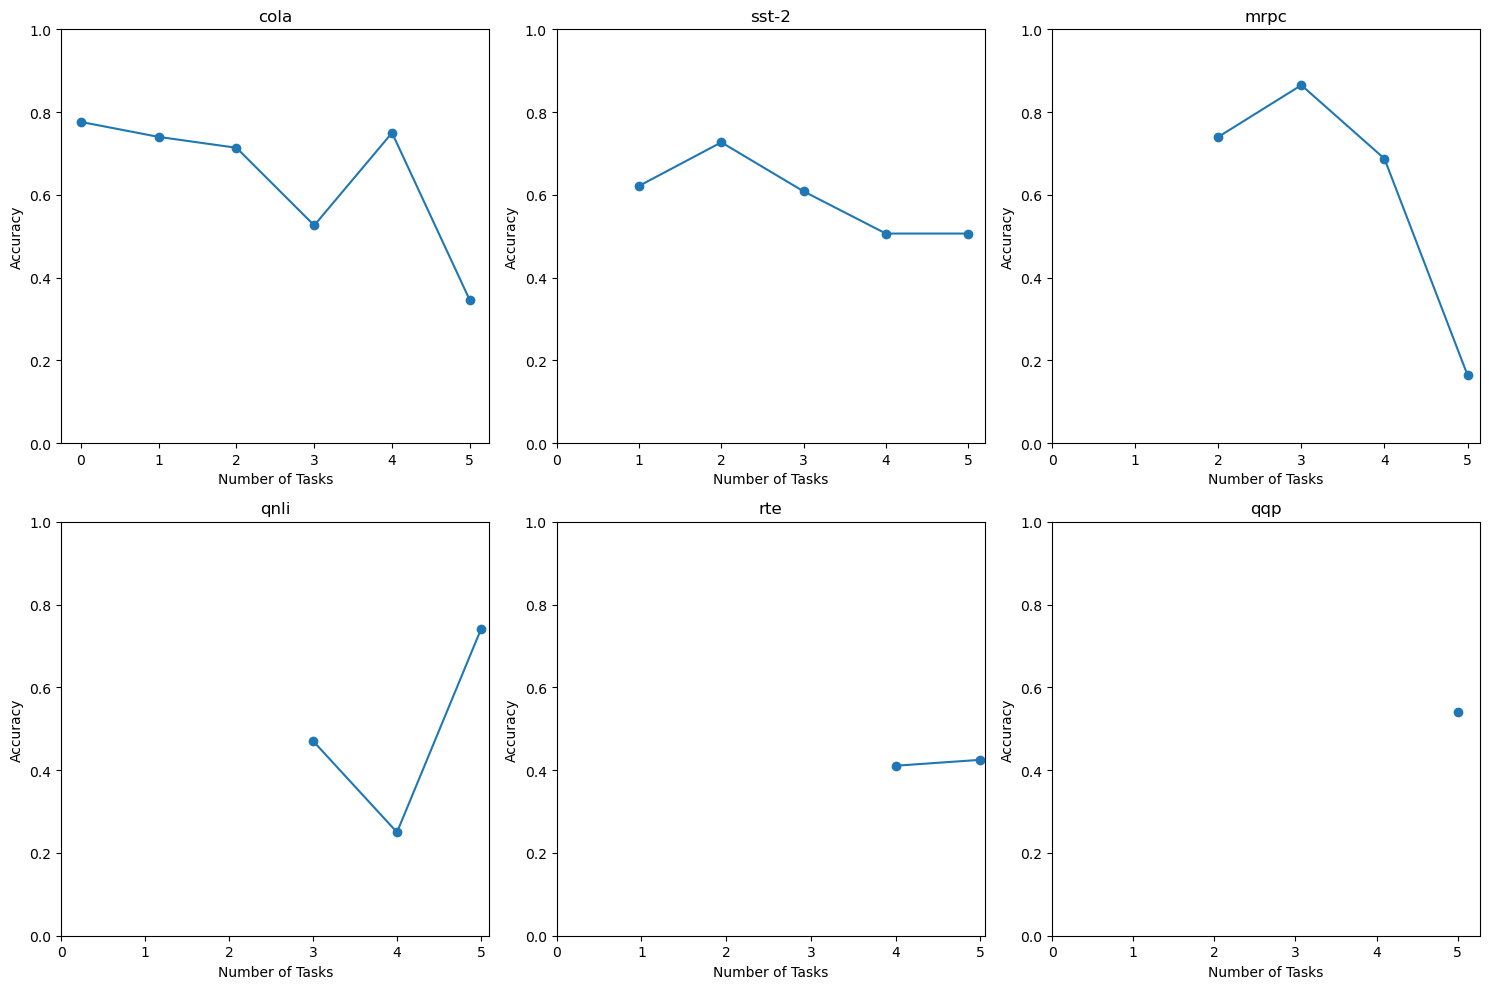

In [30]:
tasks = acc_mtx.columns 
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

# Plot accuracy for each task
for i, task in enumerate(tasks):
    accuracies = acc_mtx[task].tolist()
    x = range(len(accuracies))
    axs[i].plot(x, accuracies, marker='o')
    axs[i].set_title(task)
    axs[i].set_xlabel('Number of Tasks')
    axs[i].set_ylabel('Accuracy')
    axs[i].set_xticks(x)
    axs[i].set_xticklabels([str(j) for j in range(len(accuracies))])
    axs[i].set_ylim(0, 1)

plt.tight_layout()
plt.savefig(os.path.join(args.output_dir, "accuracy_bertbase_res2.png"))
plt.show()

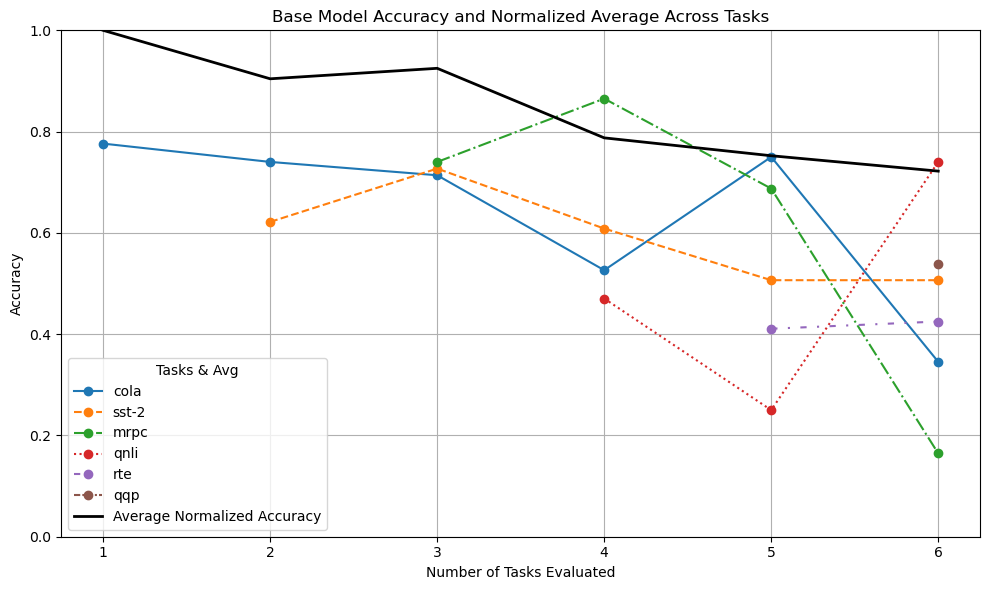

In [28]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
line_styles = ['-', '--', '-.', ':', (0, (3, 5, 1, 5)), (0, (3, 1, 1, 1))]

fig, ax = plt.subplots(figsize=(10, 6))

# Normalize accuracies by the maximum accuracy obtained right after training for each task
normalized_acc_mtx = acc_mtx.divide(acc_mtx.max())

# Calculate the average of normalized accuracies
average_normalized_acc = normalized_acc_mtx.mean(axis=1)

for i, task in enumerate(tasks):
    accuracies = acc_mtx[task].tolist()
    x = range(len(accuracies))
    ax.plot(x, accuracies, marker='o', color=colors[i % len(colors)], linestyle=line_styles[i % len(line_styles)], label=task)

ax.plot(x, average_normalized_acc, 'k-', linewidth=2, label='Average Normalized Accuracy')

ax.set_title('Base Model Accuracy and Normalized Average Across Tasks')
ax.set_xlabel('Number of Tasks Evaluated')
ax.set_ylabel('Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(range(1, len(average_normalized_acc) + 1))
ax.set_ylim(0, 1)
ax.legend(title="Tasks & Avg")

plt.tight_layout()
plt.grid(True)
plt.savefig(os.path.join(args.output_dir, "base_accuracy_plots.png"))
plt.show()


In [20]:
average_normalized_acc

0    1.000000
1    0.904297
2    0.925002
3    0.787656
4    0.752355
5    0.721977
dtype: float64